# Transformer Model Training
This notebook demonstrates training a transformer model for lens performance prediction using PyTorch.

### Initial Setup

In [10]:
# 1. Clone the repository
!git clone https://github.com/ruthshiferaw/2.156-Lens-Project.git

# 2. Navigate into the folder (This is crucial!)
%cd 2.156-Lens-Project

# 3. Verify you see your files
!ls

Cloning into '2.156-Lens-Project'...
remote: Enumerating objects: 16152, done.
remote: Counting objects: 100% (781/781), done.
remote: Compressing objects: 100% (767/767), done.
remote: Total 16152 (delta 38), reused 17 (delta 14), pack-reused 15371 (from 4)
Receiving objects: 100% (16152/16152), 281.80 MiB | 17.06 MiB/s, done.
Resolving deltas: 100% (4347/4347), done.
Updating files: 100% (13224/13224), done.
/content/2.156-Lens-Project/2.156-Lens-Project
 artifacts				    'Papers Repo'
 best_surface_transformer_imputed_mean.pth  'Prime Lenses + Data'
 best_surface_transformer_no_impute.pth      PythonZOSConnection.py
'Data Extraction Routines'		     RemovingFailed.py
 lens.code-workspace			     requirements.txt
'Lens Project.pdf'			     transfomer_TRK_1056PM1205.ipynb
 lens_transformer_model.pth		     transfomer_TRK.ipynb
'Mid-Project Progress Report.docx'


In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import time
import os
import pandas as pd
import math
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset
import numpy as np

# --- 1. SETUP & PATHS ---
# Detect GPU (Mac uses 'mps', NVIDIA uses 'cuda', else 'cpu')
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Training on: {device}")

current_folder = os.getcwd()
data_folder = os.path.join(current_folder, "Prime Lenses + Data", "LensDataExports")
summary_file = os.path.join(current_folder, "Prime Lenses + Data", "CSVExports", "file_lens_summary.csv")

print(f"Loading summary from: {summary_file}")
print(f"Loading lens data from: {data_folder}")

# Hyperparameters
BATCH_SIZE = 16
LEARNING_RATE = 1e-4
EPOCHS = 50

Training on: cuda
Loading summary from: /content/2.156-Lens-Project/2.156-Lens-Project/Prime Lenses + Data/CSVExports/file_lens_summary.csv
Loading lens data from: /content/2.156-Lens-Project/2.156-Lens-Project/Prime Lenses + Data/LensDataExports


In [12]:
# ==========================================
# 2. DATASET (FIXED: MASK LOGIC)
# ==========================================
import os
import pandas as pd
import torch
from torch.utils.data import Dataset
from torch.nn.utils.rnn import pad_sequence
import numpy as np

def index_lens_files(root_dir, ignore_files=None):
    if ignore_files is None: ignore_files = []
    path_map = {}
    print(f"Scanning {root_dir} for lens files...")
    for root, dirs, files in os.walk(root_dir):
        for file in files:
            if file.endswith(".csv"):
                if file in ignore_files: continue
                lens_name = os.path.splitext(file)[0]
                full_path = os.path.join(root, file)
                path_map[lens_name] = full_path
    print(f"Found {len(path_map)} lens files.")
    return path_map

class LensPerformanceDataset(Dataset):
    def __init__(self, summary_file, lens_data_root, material_vocab=None):
        self.summary_df = pd.read_csv(summary_file)
        summary_filename = os.path.basename(summary_file)
        self.file_path_map = index_lens_files(lens_data_root, ignore_files=[summary_filename])

        self.surface_columns = ['Surface', 'TypeName', 'Comment', 'Radius', 'Thickness', 'Material', 'SemiDiameter']
        self.numeric_features = ['Radius', 'Thickness', 'SemiDiameter']
        self.categorical_feature = 'Material'

        # Dynamic Targets
        all_numeric = self.summary_df.select_dtypes(include=['number']).columns.tolist()
        ignore_cols = ['File Name', 'Unnamed: 0']
        self.target_cols = [c for c in all_numeric if c not in ignore_cols]
        print(f"🎯 Auto-Detected {len(self.target_cols)} Targets")

        if material_vocab is None:
            self.material_vocab = self._build_vocab()
        else:
            self.material_vocab = material_vocab

        self.input_stats = self._compute_input_stats()
        self.target_stats = self._compute_target_stats()

    def _build_vocab(self):
        unique_materials = set(['Air'])
        for lens_name, file_path in self.file_path_map.items():
            try:
                df = pd.read_csv(file_path, usecols=[self.categorical_feature])
                unique_materials.update(df[self.categorical_feature].astype(str).unique())
            except: pass
        return {name: i for i, name in enumerate(sorted(unique_materials))}

    def _safe_preprocess(self, df):
        data = df[self.numeric_features].values.astype(np.float32)

        # Radius -> Curvature
        radius = data[:, 0]
        radius = np.where(np.abs(radius) > 1e6, np.inf, radius)
        with np.errstate(divide='ignore'):
            curvature = np.where(np.isfinite(radius) & (radius != 0), 1.0 / radius, 0.0)
        data[:, 0] = curvature

        # Clamp & Log1p
        data[:, 1] = np.log1p(np.clip(data[:, 1], 0, 1000.0))
        data[:, 2] = np.log1p(np.clip(data[:, 2], 0, 1000.0))
        return data

    def _compute_input_stats(self):
        print("Computing INPUT stats...")
        all_data = []
        sample_keys = list(self.file_path_map.keys())[:300]
        for key in sample_keys:
            try:
                path = self.file_path_map[key]
                df = pd.read_csv(path, usecols=self.numeric_features)
                df = df.replace([np.inf, -np.inf], np.nan).fillna(0)
                processed = self._safe_preprocess(df)
                all_data.append(processed)
            except: pass

        if not all_data: return {'mean': np.zeros(3), 'std': np.ones(3)}
        all_data = np.vstack(all_data)
        mean = np.mean(all_data, axis=0)
        std = np.std(all_data, axis=0)
        std = np.where(std < 1e-6, 1.0, std)
        print(f"Inputs -> Mean: {mean}, Std: {std}")
        return {'mean': mean, 'std': std}

    def _compute_target_stats(self):
        print("Computing TARGET stats...")
        target_vals = self.summary_df[self.target_cols].values.astype(np.float32)
        target_vals = np.nan_to_num(target_vals, nan=0.0)
        mean = np.mean(target_vals, axis=0)
        std = np.std(target_vals, axis=0)
        std = np.where(std < 1e-6, 1.0, std)
        return {'mean': torch.tensor(mean, dtype=torch.float32),
                'std': torch.tensor(std, dtype=torch.float32)}

    def __len__(self):
        return len(self.summary_df)

    def __getitem__(self, idx):
        row = self.summary_df.iloc[idx]
        lens_name = row['File Name']
        lookup_name = lens_name + "_LensData"

        if lookup_name not in self.file_path_map:
            if lens_name in self.file_path_map: lookup_name = lens_name
            else: return None

        try:
            lens_df = pd.read_csv(self.file_path_map[lookup_name], usecols=self.surface_columns)
            lens_df[self.numeric_features] = lens_df[self.numeric_features].replace([np.inf, -np.inf], np.nan).fillna(0)

            numeric_data = self._safe_preprocess(lens_df)
            norm_numeric = (numeric_data - self.input_stats['mean']) / (self.input_stats['std'])
            lens_numeric = torch.tensor(norm_numeric, dtype=torch.float32)

            materials = lens_df[self.categorical_feature].astype(str).map(self.material_vocab).fillna(0)
            lens_material_ids = torch.tensor(materials.values, dtype=torch.long)

            raw_targets = row[self.target_cols].values.astype(float)
            raw_targets = np.nan_to_num(raw_targets, nan=0.0)
            raw_t_tensor = torch.tensor(raw_targets, dtype=torch.float32)
            norm_targets = (raw_t_tensor - self.target_stats['mean']) / self.target_stats['std']

            return {'numeric_seq': lens_numeric, 'material_seq': lens_material_ids, 'targets': norm_targets}
        except Exception as e:
            return None

# --- FIXED COLLATE FUNCTION ---
def lens_collate_fn(batch):
    batch = [item for item in batch if item is not None]
    if len(batch) == 0: return None

    numeric_seqs = [item['numeric_seq'] for item in batch]
    material_seqs = [item['material_seq'] for item in batch]
    targets = [item['targets'] for item in batch]

    padded_numeric = pad_sequence(numeric_seqs, batch_first=True, padding_value=0.0)
    padded_materials = pad_sequence(material_seqs, batch_first=True, padding_value=0)

    # === CRITICAL FIX: True = PADDING (Ignore), False = DATA (Keep) ===
    # We check if numeric is all zeros (padding) AND material is 0 (padding)
    padding_mask = (padded_materials == 0) & (padded_numeric.abs().sum(dim=2) == 0)

    return {'numeric_seq': padded_numeric, 'material_seq': padded_materials, 'mask': padding_mask, 'targets': torch.stack(targets)}

In [13]:
# ==========================================
# 3. TRANSFORMER MODEL
# ==========================================
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=100):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        return x + self.pe[:, :x.size(1), :]

class LensTransformer(nn.Module):
    def __init__(self, num_materials, d_model=64, nhead=4, num_layers=3, output_dim=2):
        super().__init__()
        # 1. Embeddings
        self.mat_embed = nn.Embedding(num_materials, 16)
        self.num_embed = nn.Linear(3, d_model - 16)

        self.pos_encoder = PositionalEncoding(d_model)

        # 2. Transformer
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # 3. Prediction Head (Using the Mean-Pooled Giga Vector)
        self.head = nn.Sequential(
            nn.Linear(d_model, 32),
            nn.ReLU(),
            nn.Linear(32, output_dim)
        )

    def forward(self, numeric_seq, material_seq, src_key_padding_mask):
        # Embed
        mat_vecs = self.mat_embed(material_seq)
        num_vecs = self.num_embed(numeric_seq)
        x = torch.cat([num_vecs, mat_vecs], dim=2)

        # Transform
        x = self.pos_encoder(x)
        x = self.transformer(x, src_key_padding_mask=src_key_padding_mask)

        # Mean Pooling (Collapse N surfaces -> 1 Giga Vector)
        valid_mask = (~src_key_padding_mask).unsqueeze(-1).float()
        sum_embeddings = (x * valid_mask).sum(dim=1)
        num_valid = valid_mask.sum(dim=1)
        lens_vector = sum_embeddings / (num_valid + 1e-9)

        # Predict
        return self.head(lens_vector)

In [14]:
# ==========================================
# 4. TRAINING LOOP
# ==========================================

full_dataset = LensPerformanceDataset(summary_file, data_folder)
if len(full_dataset) == 0: raise ValueError("Dataset is empty! Check paths.")

train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=lens_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, collate_fn=lens_collate_fn)

# Dynamic Config
num_materials = len(full_dataset.material_vocab)
num_targets = len(full_dataset.target_cols)

print(f"Vocab Size: {num_materials}")
print(f"Predicting {num_targets} metrics")

# Model
model = LensTransformer(num_materials=num_materials, d_model=64, output_dim=num_targets).to(device)

criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4)

print("\n--- Starting Training ---")
for epoch in range(50):
    model.train()
    running_loss = 0.0
    for batch in train_loader:
        if batch is None: continue

        # Safety Check
        if (torch.isnan(batch['numeric_seq']).any() or torch.isinf(batch['numeric_seq']).any() or batch['mask'].sum() == 0):
            continue

        numeric = batch['numeric_seq'].to(device)
        material = batch['material_seq'].to(device)
        mask = batch['mask'].to(device)
        targets = batch['targets'].to(device)

        optimizer.zero_grad()
        predictions = model(numeric, material, mask)
        loss = criterion(predictions, targets)
        loss.backward()

        # --- KEY FIX: GRADIENT CLIPPING ---
        # If gradients explode, clip them to 1.0
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        if (torch.isnan(predictions).any() or torch.isinf(predictions).any()):
            print("NaN detected! Clipping saved us.")
            continue

        optimizer.step()
        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader) if len(train_loader) > 0 else 0.0

    model.eval()
    running_test_loss = 0.0
    with torch.no_grad():
        for batch in test_loader:
            if batch is None: continue
            numeric = batch['numeric_seq'].to(device)
            material = batch['material_seq'].to(device)
            mask = batch['mask'].to(device)
            targets = batch['targets'].to(device)
            loss = criterion(model(numeric, material, mask), targets)
            running_test_loss += loss.item()

    avg_test_loss = running_test_loss / len(test_loader) if len(test_loader) > 0 else 0.0

    if (epoch + 1) % 5 == 0 or epoch == 0:
        print(f"Epoch [{epoch+1}/50] Train Loss: {avg_train_loss:.4f} | Test Loss: {avg_test_loss:.4f}")

print("Done! Saving model...")
torch.save(model.state_dict(), "lens_transformer_model.pth")

Scanning /content/2.156-Lens-Project/2.156-Lens-Project/Prime Lenses + Data/LensDataExports for lens files...
Found 1019 lens files.
🎯 Auto-Detected 11 Targets
Computing INPUT stats...
Inputs -> Mean: [0.01351134 1.3206878  2.4531727 ], Std: [0.28659356 1.0645258  0.94376355]
Computing TARGET stats...
Vocab Size: 1554
Predicting 11 metrics

--- Starting Training ---
Epoch [1/50] Train Loss: 0.0000 | Test Loss: 0.0515
Epoch [5/50] Train Loss: 0.0000 | Test Loss: 0.0414
Epoch [10/50] Train Loss: 0.0216 | Test Loss: 0.0364
Epoch [15/50] Train Loss: 0.0000 | Test Loss: 0.0364
Epoch [20/50] Train Loss: 0.0000 | Test Loss: 0.0316
Epoch [25/50] Train Loss: 0.0000 | Test Loss: 0.0284
Epoch [30/50] Train Loss: 0.0021 | Test Loss: 0.0279
Epoch [35/50] Train Loss: 0.0000 | Test Loss: 0.0279
Epoch [40/50] Train Loss: 0.0866 | Test Loss: 0.0287
Epoch [45/50] Train Loss: 0.0000 | Test Loss: 0.0323
Epoch [50/50] Train Loss: 0.0000 | Test Loss: 0.0346
Done! Saving model...



--- Generating Predictions for Plotting ---
Plots saved to 'predicted_vs_actual_plots.png'


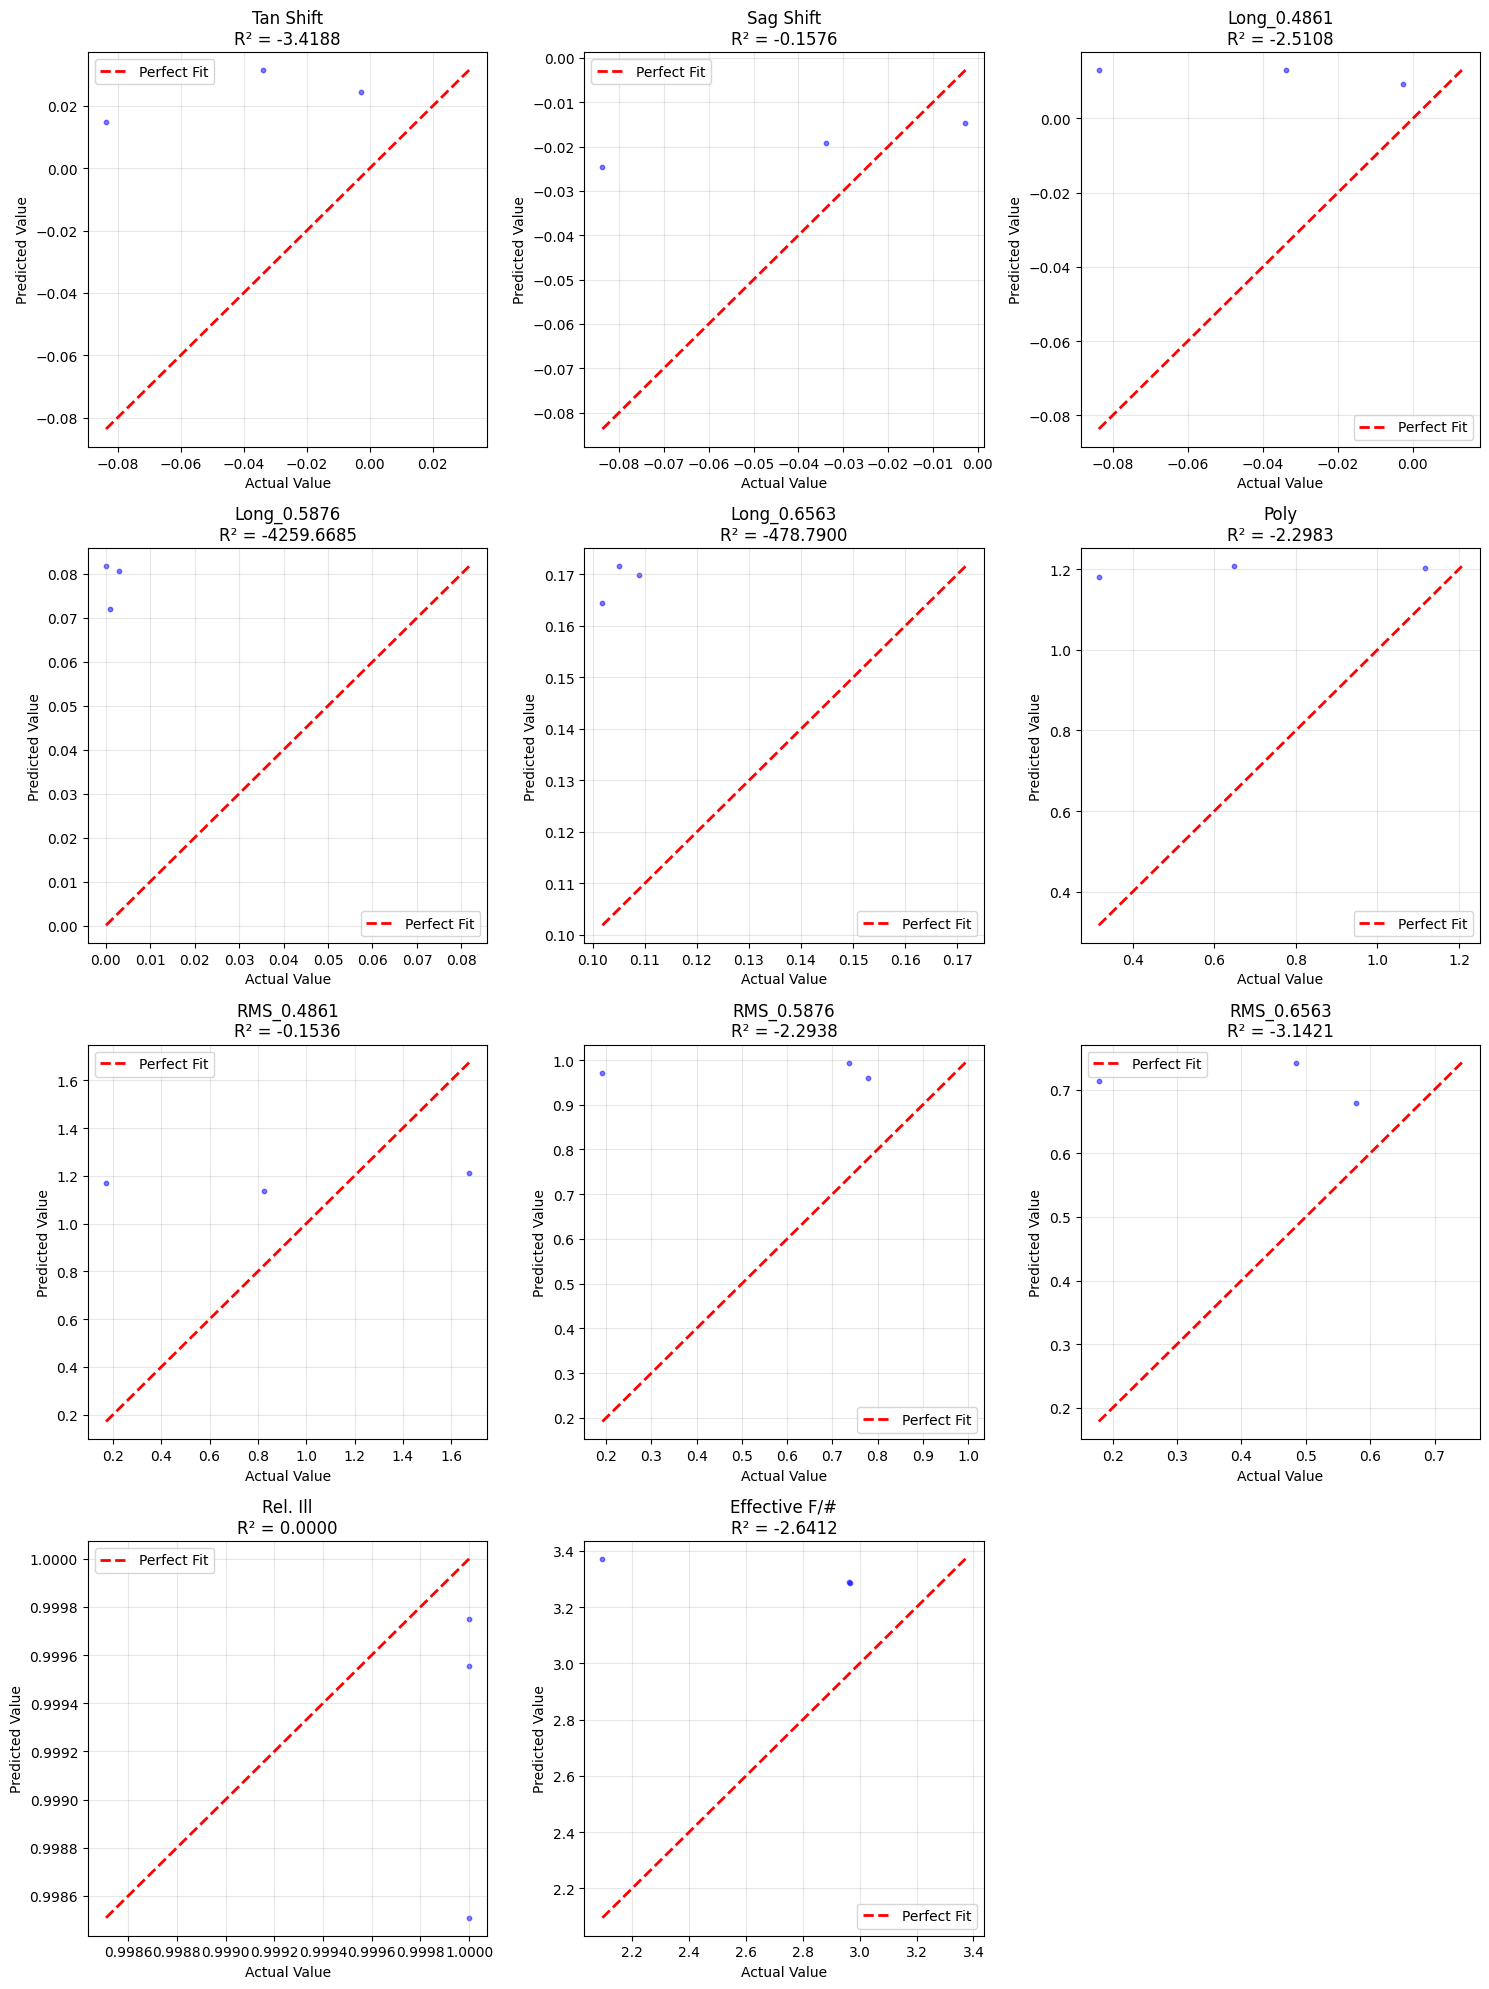

In [18]:
# ==========================================
# 5. EVALUATION & PLOTTING
# ==========================================
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

model.eval()
all_preds = []
all_targets = []

print("\n--- Generating Predictions for Plotting ---")
with torch.no_grad():
    for batch in test_loader:
        if batch is None: continue

        # Load batch
        numeric = batch['numeric_seq'].to(device)
        material = batch['material_seq'].to(device)
        mask = batch['mask'].to(device)
        targets = batch['targets'].to(device)

        # Predict
        preds = model(numeric, material, mask)

        # Move to CPU for plotting
        all_preds.append(preds.cpu().numpy())
        all_targets.append(targets.cpu().numpy())

# Concatenate all batches
all_preds = np.vstack(all_preds)
all_targets = np.vstack(all_targets)

# --- UN-NORMALIZE DATA ---
# We need to reverse: norm = (raw - mean) / std
# So: raw = (norm * std) + mean
t_mean = full_dataset.target_stats['mean'].numpy()
t_std = full_dataset.target_stats['std'].numpy()

real_preds = (all_preds * t_std) + t_mean
real_targets = (all_targets * t_std) + t_mean

# --- PLOTTING ---
# We have `num_targets` metrics. We'll make a grid of subplots.
cols = 3
rows = math.ceil(num_targets / cols)
fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
axes = axes.flatten()

target_names = full_dataset.target_cols

for i in range(num_targets):
    ax = axes[i]
    y_true = real_targets[:, i]
    y_pred = real_preds[:, i]

    # Calculate R^2
    r2 = r2_score(y_true, y_pred)

    # Scatter Plot
    ax.scatter(y_true, y_pred, alpha=0.5, s=10, color='blue')

    # Identity Line (Perfect Prediction)
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Fit')

    ax.set_title(f"{target_names[i]}\nR² = {r2:.4f}")
    ax.set_xlabel("Actual Value")
    ax.set_ylabel("Predicted Value")
    ax.grid(True, alpha=0.3)
    ax.legend()

# Hide empty subplots if any
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig("predicted_vs_actual_plots.png", dpi=300)
print(f"Plots saved to 'predicted_vs_actual_plots.png'")
plt.show()

In [15]:
# old code predicting just 2
# ==========================================
# DIAGNOSTIC: Count and inspect non-skipped batches
# ==========================================
processed_batches = 0
loader_iter = iter(train_loader)
for i in range(20):  # Check up to 20 batches
    try:
        batch = next(loader_iter)
        if batch is None:
            print(f"Batch {i}: None")
            continue
        if (
            torch.isnan(batch['numeric_seq']).any() or
            torch.isinf(batch['numeric_seq']).any() or
            torch.isnan(batch['material_seq']).any() or
            torch.isinf(batch['material_seq']).any() or
            torch.isnan(batch['targets']).any() or
            torch.isinf(batch['targets']).any() or
            batch['mask'].sum() == 0
        ):
            print(f"Batch {i}: Skipped due to NaN/Inf or empty mask")
            continue
        processed_batches += 1
        print(f"Batch {i}: PROCESSED")
        print("numeric_seq:", batch['numeric_seq'])
        print("material_seq:", batch['material_seq'])
        print("mask:", batch['mask'])
        print("targets:", batch['targets'])
        break  # Only print the first valid batch
    except StopIteration:
        print(f"Batch {i}: End of loader")
        break
    except Exception as e:
        print(f"Batch {i}: Exception {e}")
print(f"Total non-skipped batches found: {processed_batches}")






Batch 0: None
Batch 1: None
Batch 2: None
Batch 3: None
Batch 4: None
Batch 5: Skipped due to NaN/Inf or empty mask
Batch 6: None
Batch 7: Skipped due to NaN/Inf or empty mask
Batch 8: None
Batch 9: None
Batch 10: None
Batch 11: None
Batch 12: None
Batch 13: None
Batch 14: None
Batch 15: None
Batch 16: None
Batch 17: None
Batch 18: None
Batch 19: None
Total non-skipped batches found: 0


In [17]:
print(f"Found {len(path_map)} lens files.")

NameError: name 'path_map' is not defined

## Debugging

In [ ]:
# ==========================================
# BATCH AND TARGET DIAGNOSTICS BEFORE TRAINING
# ==========================================
loader_iter = iter(train_loader)
for i in range(3):
    try:
        batch = next(loader_iter)
        if batch is None:
            print(f"Batch {i}: None")
            continue
         print(f"Batch {i}: Numeric shape {batch['numeric_seq'].shape}, Material shape {batch['material_seq'].shape}, Targets shape {batch['targets'].shape}")
        print(f"Batch {i} targets: {batch['targets']}")
        # Check for NaNs/Infs
        for key in ['numeric_seq', 'material_seq', 'targets']:
            arr = batch[key]
            if torch.isnan(arr).any():
                print(f"Batch {i}: {key} contains NaNs!")
            if torch.isinf(arr).any():
                print(f"Batch {i}: {key} contains Infs!")
    except StopIteration:
        print(f"Batch {i}: End of loader")
        break
    except Exception as e:
        print(f"Batch {i}: Exception {e}")

Model training complete. The transformer weights are saved to `lens_transformer_model.pth`.

In [ ]:
# ==========================================
# DEBUGGING DATASET AND DATALOADER
# ==========================================
print("\n--- Dataset Debugging ---")
invalid_count = 0
valid_count = 0
for idx in range(len(full_dataset)):
    row = full_dataset.summary_df.iloc[idx]
    lens_name = row['File Name']+"_LensData"
    print(f"Index {idx}: Lens Name = {lens_name}", end=' ')
    if lens_name not in full_dataset.file_path_map:
        print("[MISSING FILE]")
        invalid_count += 1
        continue
    try:
        item = full_dataset[idx]
        if item is None:
            print("[ITEM NONE]")
            invalid_count += 1
        else:
            print("[VALID]")
            valid_count += 1
    except Exception as e:
        print(f"[EXCEPTION] {e}")
        invalid_count += 1
print(f"\nTotal valid items: {valid_count}")
print(f"Total invalid/missing items: {invalid_count}")

print("\n--- DataLoader Batch Debugging ---")
loader_iter = iter(train_loader)
for i in range(3):
    try:
        batch = next(loader_iter)
        if batch is None:
            print(f"Batch {i}: None")
        else:
            print(f"Batch {i}: Numeric shape {batch['numeric_seq'].shape}, Material shape {batch['material_seq'].shape}, Targets shape {batch['targets'].shape}")
    except StopIteration:
        print(f"Batch {i}: End of loader")
        break
    except Exception as e:
        print(f"Batch {i}: Exception {e}")

In [ ]:
# ==========================================
# BATCH AND TARGET DIAGNOSTICS BEFORE TRAINING
# ==========================================
loader_iter = iter(train_loader)
for i in range(3):
    try:
        batch = next(loader_iter)
        if batch is None:
            print(f"Batch {i}: None")
            continue
        print(f"Batch {i}: Numeric shape {batch['numeric_seq'].shape}, Material shape {batch['material_seq'].shape}, Targets shape {batch['targets'].shape}")
        print(f"Batch {i} targets: {batch['targets']}")
        # Check for NaNs/Infs
        for key in ['numeric_seq', 'material_seq', 'targets']:
            arr = batch[key]
            if torch.isnan(arr).any():
                print(f"Batch {i}: {key} contains NaNs!")
            if torch.isinf(arr).any():
                print(f"Batch {i}: {key} contains Infs!")
    except StopIteration:
        print(f"Batch {i}: End of loader")
        break
    except Exception as e:
        print(f"Batch {i}: Exception {e}")